<a href="https://colab.research.google.com/github/avocadopelvis/deep-mozart/blob/main/data-preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install dependencies
# !pip install music21 
# !apt-get install -y lilypond

In [3]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.model_selection import train_test_split

import music21
from music21 import *

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

import os
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

import json
import random
import IPython
from IPython.display import Image, Audio
from collections import Counter

In [4]:
# load the list of chopin's MIDI files as stream
path = "/content/drive/MyDrive/ML PROJECT/mozart/"

# get midi files
midis = []
for i in os.listdir(path):
    if i.endswith(".mid"):
        tr = path+i
        midi = converter.parse(tr)
        midis.append(midi)

In [6]:
# function to extract notes
def extract_notes(file):
    notes = []
    pick = None
    for i in file:
        songs = instrument.partitionByInstrument(i)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
                    
                    
    return notes

# get the list of notes as a corpus
corpus = extract_notes(midis)
print("Total notes in all the Mozart MIDIs in the dataset:", len(corpus))

Total notes in all the Mozart MIDIs in the dataset: 59618


### Data Exploration

In [7]:
print("First fifty values in the corpus:\n", corpus[:50])

First fifty values in the corpus:
 ['4.7', '4.7', '0.4', '9.0', '9.0', '2.5', '5.9', '2.5', '11.2', '7.11', '7.11', 'C5', '4.7', 'D5', 'E5', 'C5', 'A4', 'F3', 'B4', 'C5', 'C#5', 'D5', 'E5', 'F5', 'D3', 'D5', 'C5', 'G3', 'B4', 'A4', 'G4', '4.7', '4.7', '0.4', '9.0', '9.0', '5.9', '2.5', '5.9', '11.2', '7.11', '7.11', 'A5', '0.4', 'G5', 'F5', 'E5', 'C#5', '5.9', 'D5']


The above values indicate the notes.

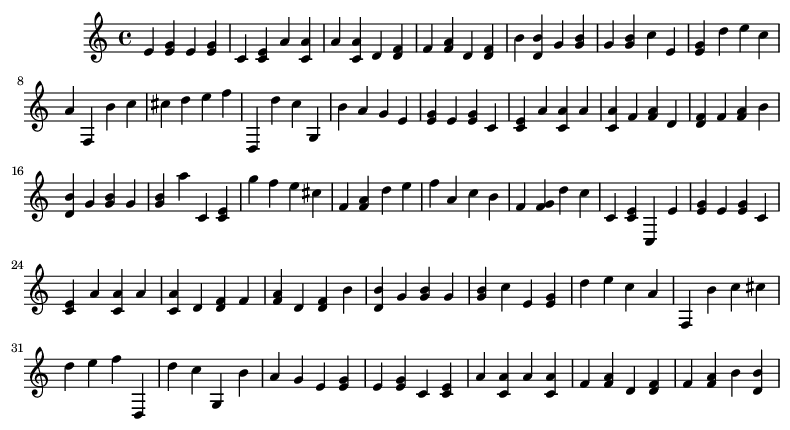

In [8]:
# function to display music sheet
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chord_n_notes(snippet):
    melody = []
    offset = 0
    for i in snippet:
        # if it is chord
        if "." in i or i.isdigit():
            # seperate the notes in chords
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                melody.append(chord_snip)
        # if it is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    
    melody_midi = stream.Stream(melody)
    return melody_midi

melody_snippet = chord_n_notes(corpus[:100])
show(melody_snippet)

In [19]:
# to play audio or corpus
# print("Sample Audio From Data")
# IPython.display.Audio("/content/drive/MyDrive/ML PROJECT/mozart-1.wav") 

In [12]:
# create a count dictionary
count = Counter(corpus)
print("Total unique notes in the corpus:", len(count))

Total unique notes in the corpus: 197


In [13]:
# explore the notes dictionary
notes = list(count.keys())
recurrence = list(count.values())

# function to find average recurrence for a note in corpus
def average(lst):
  return sum(lst)/len(lst)

print("Average recurrence of a note in corpus:", average(recurrence))
print("Most frequent note in corpus appeared:", max(recurrence), "times")
print("Least frequent note in corpus appeared:", min(recurrence), "time")

Average recurrence of a note in corpus: 302.6294416243655
Most frequent note in corpus appeared: 3116 times
Least frequent note in corpus appeared: 1 time


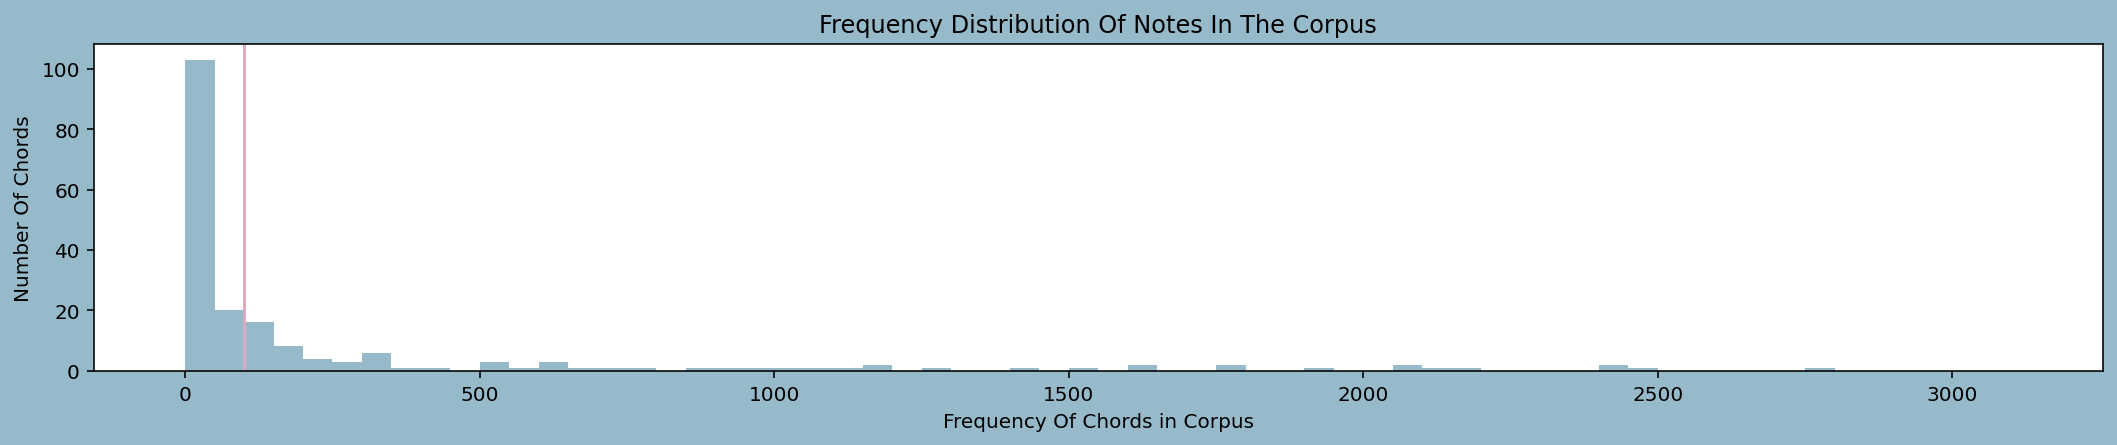

In [14]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(recurrence)), 50) 
plt.hist(recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

The notes that were played less than 100 times will be removed.

In [15]:
# get a list of rare notes
rare_note = []
for i, (key, value) in enumerate(count.items()):
  if value < 100:
    m = key
    rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 123


In [16]:
# eliminate the rare notes
for element in corpus:
  if element in rare_note:
    corpus.remove(element)

print("Length of corpus after elimination of the rare notes:", len(corpus))

Length of corpus after elimination of the rare notes: 57247


In [17]:
# save corpus
with open("data.txt", 'w') as f:
  json.dump(corpus, f)

In [18]:
# load corpus
# with open("data.txt", 'r') as f:
#   corpus = json.load(f)